---
title: Monotonic Networks
subtitle: Neural Networks as Activation Functions
date: 2025-02-26
bibliography:
  - monotonic_networks_references.bib
---

In [1]:
# Basic imports
import torch
from torch import nn
import geosimilarity as gs

from assets.utils import automate_training, plot_curves

# Creating Injective Functions with Parameters

We observed earlier that with the [`PReLU`](#parameter_insight) activation Injective Networks
perform much better. Therefore, the insight we gain that will help us power up Injective Networks is
: **add more parameters**.

One way to add parameters to the Network is to use parameterized activation functions e.g.
$\sigma(\beta x)$ i.e. the sigmoid with a parameter $\beta$ or try and create other activations.
During the creation of these parameterized activations one needs to keep in mind that injectivity
should not be violated for any parameter value to ensure that the network always represents only
simple closed curves, which is our final goal.

It is quite difficult to combine activation functions together with appropriate parameters that add
representation power while maintaining injectivity. We will therefore look at a much more drastic
and interesting approach.

First, we need to understand how we could create a function that is injective. The first step is to
realize that:
> A continuous function is injective if and only if it is strictly monotonic.[^injective_monotonic]

Therefore we can create injective functions by creating strictly monotonic functions.

[^injective_monotonic]: Math StackExchange,
    [Continuous injective map is strictly monotonic](https://math.stackexchange.com/questions/752073/continuous-injective-map-is-strictly-monotonic)

# Monotonic Networks: A Superpower

We will create injective activation functions using a drastic measure. Every activation function
will be an injective neural network!

We will create neural networks that take in a scalar input and output a scalar value and are
strictly monotonic in the input. Mathematically our activation function now is a neural network $M$
$$
M: \mathbb{R} \rightarrow \mathbb{R}
$$
which satisfies one of:
$$
M(x_1) < M(x_2) \quad \forall x_1, x_2 \in \mathbb{R} \quad s.t. \; x_1 < x_2\\
M(x_1) > M(x_2) \quad \forall x_1, x_2 \in \mathbb{R} \quad s.t. \; x_1 > x_2
$$

:::{card}
:header: Monotonic Networks
:footer: [@sill1997monotonic; @igel2023smooth; @runje2023constrained; @daniels2010monotone]
We will choose neural networks that _by design_ for _any_ parameter value are always monotonic,
these are called **_Monotonic Networks_**.
:::

Every activation layer will be an independent Monotonic Network and all neurons will use the same
neural network. This is shown in [](#neural_injective_geometry_net).
:::{figure} assets/neural_injective_geometry_net
:label: neural_injective_geometry_net
:alt: Injective Networks with Monotonic Networks as activation functions
:height: 210px
Injective Network with Monotonic Networks as activation functions. $M_1$ shown in the figure is a
monotonic network.
:::

## Building Monotonic Networks with Smooth Min-Max Networks
Building Monotonic Networks is an active area of research and there are a few popular choices. The
first Monotonic Network was designed by @sill1997monotonic which used $min$ and $max$ operations to
impart monotonicity. But since the $min-max$ operations are not differentiable they are hard
to train and also suffer from dead neurons[^dead_neurons]. Recently @igel2023smooth proposed a
variation of the original Monotonic Networks proposed by @sill1997monotonic, which replaces the hard
$min-max$ with their smooth variants. These are called Smooth Min-Max Monotonic Networks.

We will use Smooth Min-Max Monotonic Networks as activation functions to augment Injective Networks.
We use the code provided in Christian's Repository
[https://github.com/christian-igel/SMM](https://github.com/christian-igel/SMM) as reference for our
own code.

**_Note:_** To ensure positive weights for monotonicity constraints we provide two options.
- Exponential positivity: $w = e^z$ - @igel2023smooth and @sill1997monotonic
- Squared positivity: $w = z^2$ - @daniels2010monotone

By default monotonic networks provided in the NIGnets module use squared positivity constraints as
they were found to perform slightly better.

[^dead_neurons]: Data Science StackExchange
    [What is the "dying ReLU" problem in neural networks?](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks)

To use monotonic networks with NIGnets, create a monotonic network of a particular architecture and
pass that as an input to NIGnets. NIGnets under the hood creates deepcopies using the same
architecture and uses different monotonic networks at each layer. The NIGnets package comes with
an implementation of some popular
[monotonic networks](https://github.com/atharvaaalok/NIGnets/tree/main/NIGnets/monotonic_nets) that
can be used directly without installing additional dependencies.

In [22]:
from NIGnets import NIGnet
from NIGnets.monotonic_nets import SmoothMinMaxNet

monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 6, nodes_per_group = 6)
bunny_net = NIGnet(layer_count = 5, monotonic_net = monotonic_net)

Epoch: [    1/10000]. Loss:    0.817833
Epoch: [ 2000/10000]. Loss:    0.001536
Epoch: [ 4000/10000]. Loss:    0.000603
Epoch: [ 6000/10000]. Loss:    0.000363
Epoch: [ 8000/10000]. Loss:    0.000280
Epoch: [10000/10000]. Loss:    0.000265


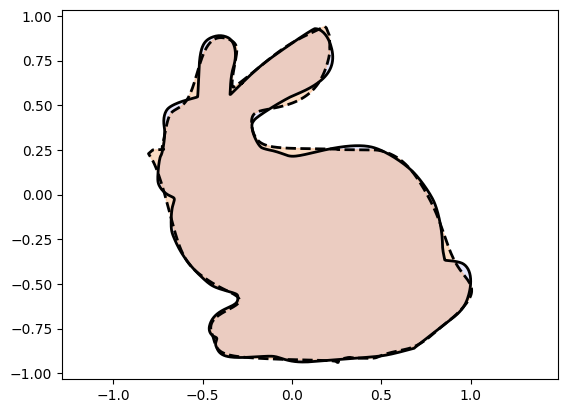

In [23]:
from assets.shapes import stanford_bunny

# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
Xt_bunny = stanford_bunny(num_pts)

automate_training(
    model = bunny_net, loss_fn = gs.MSELoss(), X_train = t, Y_train = Xt_bunny,
    learning_rate = 0.1, epochs = 10000, print_cost_every = 2000
)

Xc_bunny = bunny_net(t)
plot_curves(Xc_bunny, Xt_bunny)

We observe an amazing improvement! Using Monotonic Networks as activation functions bolsters
Injective Networks by introducing a lot of parameters which can be tuned to fit shapes with high
accuracy.

## Skip Connections: ResNet Style

The [Residual Network (ResNet)](https://en.wikipedia.org/wiki/Residual_neural_network) architecture
has made training easier for deeper networks. We can similarly use skip connections with monotonic
networks as they preserve monotonicity and hence injectivity. This will allow us to train deeper
NIGnets. The skip connection connects the input with the output of a subnetwork. This is shown in
[](#skip_connection).
:::{figure} assets/skip_connection.svg
:label: skip_connection
:alt: Skip connection diagram
:height: 225px
Skip connections connect the input $x$ with the output of a subnetwork $F(x)$. This allows gradients
to flow directly from the loss to each layer.
:::

We now see that we can have skip connections after each layer in NIGnets and still maintain
injectivity of the layers separately and therefore of the network as a whole.

Linear Layers
: Each linear layer performs the operation $y = Ax$. Adding a skip connection would lead to:
$$y = Ax + x = (A + I)x$$
A skip connection is mathematically unnecessary in a mathematical sense as we can think of any
transformation $Ax$ to be composed of $(B + I)x$ and view $B$ as our weight matrix for the layer
instead. In fact using skip connections with the [](#impossible_intersection) can lead to
non-invertible matrices and violate the hard guarantee on injectivity. This is because even though
$e^{A}$ is always invertible, $e^{A} + I$ is not and may even be the $0$ matrix. Thus, we do not use
skip connections with the linear layer.

Nonlinear Layers
: For the nonlinear transformations we use some injective scalar-valued mapping, which is either an
activation function or a monotonic network. Assuming that the mapping is an increasing monotonic
function $M(x)$. Then we have the layer's transformation $L(x)$ to be:
$$L(x) = M(x) + x$$
Taking derivative,
$$L'(x) = M'(x) + 1$$
now since $M(x)$ is an increasing monotonic function, $M'(x)$ is positive and hence we also have,
$$L'(x) >= 1$$
Thus the resulting transformation is also an increasing monotonic function. The derivative being
always greater than 1, might be a concern and we could additionally also include a positively
constrained scaling to $x$ as:
$$L(x) = M(x) + \alpha x$$
with,
$$L'(x) = M'(x) + \alpha >= 0$$